<div style="width: 100%; height: 50px; background-color: #add8e6"><h1 style="font-family: manrope; color: black; text-align: center; vertical-align: middle; line-height: 50px"><strong>Projeto Classificação do Booking (DHauz)</strong></h1></div> </br>

<div style="color: black; font-family: sans-serif">
Você foi contratado pela DHAUZ como cientista de dados para analisar uma base de dados de clientes de uma rede de Hotéis e sua tarefa é investigar os dados em busca de insights que possam ajudar a empresa a evitar cancelamentos e também construir um modelo preditivo que possa antecipar esses cancelamentos, de modo que a empresa tenha tempo hábil para agir com ações de retenção.

Comece respondendo as seguintes questões:
- a) Elabore hipóteses e visualizações envolvendo a variável cancellation e, pelo menos, outras
duas variáveis presentes no dataset;
- b) Desenvolva um modelo preditivo de classificação para identificar cancelamentos e utilize
métricas adequadas para argumentar a efetividade do modelo;
- c) Ao realizar a validação cruzada do modelo de classificação, discuta sobre as diferenças entre
utilizar uma separação entre treino e teste aleatória e uma separação temporal (Ex: treino em
2015 e 2016 e validação em 2017). Os resultados são diferentes? Qual o mais indicado?

<div style="color: black; font-family: sans-serif">
<h3> <strong>Aquisição de dados:</strong></h3>

- Informações sobre o dataset:    
    - As informações são anonimizadas por questões de privacidade;
    - Base de dados disponivel no link: https://dhauz-challenges.s3.amazonaws.com/cancellation_prediction.rar
    
   
       
<h3><strong>Tratamento dos dados:</strong></h3>

- Pipeline com o processamento dos dados extraídos/coletados para posterior _Essential Data Analises (EDA)_ e criação do modelo de classificação.


> **Output:** arquivos _.csv_ com os dados tratados para começarmos a preparação final para os modelos.


<h3> <strong>Criação e avaliação dos modelos:</strong></h3>

- Escolha das _features_ para treinamento dos modelos.
- Pipeline com o desenvolvimento e avaliação de diferentes modelos de classificação.


> **Output:** métricas dos modelos e arquivo _.pkl_ do melhor modelo.
</div>
<br>


#### Bibliotecas utilizadas

In [66]:
#libs 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlretrieve
import os
import shap
import itertools

# Modelo
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from explainerdashboard import ClassifierExplainer, ExplainerDashboard
from imblearn.metrics import sensitivity_score, specificity_score

from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score

from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

# Configuração do Notebook
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)
pd.options.mode.chained_assignment = None


#### Funcoes 

In [30]:
def properties(data, col):
    print('min: ', data[col].min(),
          'max: ', data[col].max(),
          'mean: ', data[col].mean(),
          'median: ', data[col].median(),
          'mode: ', data[col].mode())

def check_cols(data, columns):
    df_check = pd.DataFrame(zip(data[columns].dtypes.index, 
                                data[columns].dtypes, 
                                data[columns].nunique(), 
                                data[columns].isna().sum(),
                                round(data[columns].isna().sum()/data.shape[0], 3)*100), 
                            columns=['Variável', 'Tipo', 'Qtde_unicos', 'Qtde_NaN', '%_NaN'])
    return df_check.sort_values('Qtde_NaN').reset_index().drop('index', axis=1)

def corr_report(data, columns, min_corr=0.1):
    '''
    Análise de Correlação entre as variáveis
    '''
    corr = data[columns].corr()
    high_corr = {'Coluna1':[], 'Coluna2':[], 'Correlação':[]}
    low_corr = {'Coluna1':[], 'Coluna2':[], 'Correlação':[]}
    skip_row = []
    for idx,col in enumerate(corr.columns):
        skip_row.append(idx)
        for row in range(len(corr.columns)):
            if row in skip_row:
                continue
            if abs(round(corr.iloc[idx, row],4)) > min_corr:
                high_corr['Coluna1'].append(col)
                high_corr['Coluna2'].append(corr.columns[row])
                high_corr['Correlação'].append(round(corr.iloc[idx, row],4))
            else:
                low_corr['Coluna1'].append(col)
                low_corr['Coluna2'].append(corr.columns[row])
                low_corr['Correlação'].append(round(corr.iloc[idx, row],4))
    return low_corr, high_corr

#### 1. Aquisicão dos dados

In [31]:
df = pd.read_csv('../../Dados/Originais/cancellation_prediction.csv', sep=",") #gentileza mudar o path para rodar a base
print(f'{df.shape[0]} linhas e {df.shape[1]} colunas')

119390 linhas e 28 colunas


In [32]:
# verificando os tipos das colunas, quantidades de nan e calculando a % de nan em cada uma delas
check_cols(df, df.columns)

,Variável,Tipo,Qtde_unicos,Qtde_NaN,%_NaN
0,type,object,2,0,0.0
1,avg_price,float64,8726,0,0.0
2,customer_type,int64,4,0,0.0
3,deposit_policy,object,3,0,0.0
4,changes_between_booking_arrival,int64,21,0,0.0
5,reserved_room,object,10,0,0.0
6,num_previous_stays,int64,73,0,0.0
7,num_previous_cancellations,int64,15,0,0.0
8,repeated_guest,int64,2,0,0.0
9,distribution_channel,int64,5,0,0.0


In [33]:
cols_obj = [x for x in df.select_dtypes(include=['object']).columns]

cols_num = [x for x in df.select_dtypes(include=['int', 'int32', 'int64', 'float', 'float32', 'float64']).columns]

print(f'Total colunas tipo objeto: {len(cols_obj)}\nTotal de colunas tipo numerica: {len(cols_num)}')

Total colunas tipo objeto: 5
Total de colunas tipo numerica: 22


In [34]:
df.sample(7)

,type,cancellation,days_between_booking_arrival,year_arrival_date,month_arrival_date,week_number_arrival_date,day_of_month_arrival_date,num_weekend_nights,num_workweek_nights,num_adults,num_children,num_babies,breakfast,country,market_segment,distribution_channel,repeated_guest,num_previous_cancellations,num_previous_stays,reserved_room,changes_between_booking_arrival,deposit_policy,id_travel_agency_booking,id_person_booking,customer_type,avg_price,required_car_parking_spaces,total_of_special_requests
80714,Hotel,0,32,2015,November,47,20,0,2,1,0.0,0,True,PRT,3,2,0,0,0,A,1,No Deposit,119.0,NaN,2,73.00,0,0
55785,Hotel,1,5,2016,August,35,21,1,0,2,0.0,0,True,PRT,2,1,0,0,0,A,0,Non Refund,NaN,47.0,0,167.00,0,0
109729,Hotel,0,172,2017,April,15,13,0,3,2,1.0,0,True,ESP,2,2,0,0,0,A,0,No Deposit,9.0,NaN,0,153.00,0,2
9096,Fancy Hotel,1,117,2016,October,44,27,2,5,2,0.0,0,True,IRL,2,2,0,0,0,E,4,No Deposit,240.0,NaN,2,66.02,0,0
86814,Hotel,0,43,2016,April,15,8,0,1,2,0.0,0,True,GBR,2,2,0,0,0,A,0,No Deposit,9.0,NaN,0,117.90,0,1
8674,Fancy Hotel,1,131,2016,October,42,9,2,1,1,0.0,0,True,PRT,5,1,0,0,0,A,1,No Deposit,NaN,NaN,2,48.00,0,0
44848,Hotel,0,43,2015,October,42,13,0,1,2,0.0,0,True,PRT,3,2,0,0,0,A,0,No Deposit,63.0,NaN,2,85.00,0,0


O objetivo dessas verificações é entender como está a nossa base. </br>
Colunas que identificam IDs e estão majoritariamente nulas poderão ser removidas ao longo do processo.

#### 2. Tratamento e analise dos dados

Tratamento básicos dos dados:

In [35]:
# Removendo colunas majoritariamente nulas

print('shape inicial: ', df.shape)
cols2exc = ['id_person_booking', 'id_travel_agency_booking']
df.drop(columns=cols2exc, inplace=True)
print('shape final: ', df.shape)

shape inicial:  (119390, 28)
shape final:  (119390, 26)


In [36]:
# preenchendo como 'sem informacao' a coluna PAÍS que ontém nulos. - encoder
df['country'].fillna(value='sem informacao', inplace=True)

In [37]:
# binarizando a coluna
df['repeated_guest'] = np.where(df.repeated_guest==1,True, False)
df['repeated_guest'].value_counts()

repeated_guest
False    115580
True       3810
Name: count, dtype: int64

In [38]:
# Transformando colunas categóricas que estão no tipo numérico em categorias
cols2obj = ['type', 'customer_type', 'distribution_channel', 'market_segment', 'year_arrival_date']

for col in cols2obj:
    df[col] = df[col].astype(str)

In [39]:
# Criando coluna de data a partir das colunas que contém as partes das datas

# Mapping os nomes dos meses para números de mês:
month_map = {
    "january": 1, "february": 2, "march": 3, "april": 4,
    "may": 5, "june": 6, "july": 7, "august": 8,
    "september": 9, "october": 10, "november": 11, "december": 12
}

# Convertendo os nomes dos meses em números usando o método map
df['month_number_arrival_date'] = df['month_arrival_date'].str.lower().map(month_map)

# Nova coluna 'date_string' com o formato 'yyyy-mm-dd'
df['date_string'] = df['year_arrival_date'].astype(str) + '-' + df['month_number_arrival_date'].astype(str).str.zfill(2) + '-' + df['day_of_month_arrival_date'].astype(str).str.zfill(2)

# Convertendo a coluna 'date_string' em uma coluna de data 'arrival_date'
df['arrival_date'] = pd.to_datetime(df['date_string'])

df.drop(columns='date_string', inplace=True)

In [40]:
# Criando a coluna "total_nights"
df['total_nights'] = df['num_weekend_nights']+df['num_workweek_nights']

# Usando a coluna criada para obter "departure_date"
df['departure_date'] = df['arrival_date'] + pd.to_timedelta(df['total_nights'], unit='D')

# Criando coluna total_people referente a quantidade total de pessoas na reserva
df['total_people'] = df['num_babies']+df['num_children']+df['num_adults']

# Senoidal para organizar meses corretamente:

# Parâmetros para transformar a coluna 'month_number_arrival_date' em função senoidal
amplitude = 1.0  # Amplitude da função senoidal
offset = 0.0  # Deslocamento vertical da função senoidal
periodo = 12.0  # Período da função senoidal (número de meses em um ciclo)

# Aplicar a transformação senoidal à coluna 'mes'
df['month_sine'] = amplitude * np.sin(2 * np.pi * df['month_number_arrival_date'] / periodo) + offset

Para que seja entendido que existe um ciclo nos meses, foi aplicada a funcao senoidal para que seja feita  a distinção correta entre eles.

2.2 Aalise exploratoria

In [41]:
# Testando a provável presença de valores que representam anomalias e/ou outliers

num_cols = [
    'avg_price','num_previous_stays','num_previous_cancellations',
    'total_people','total_nights', 'days_between_booking_arrival']

for var in num_cols:
    print(f'valores para a variavel: {var}')
    properties(df, var) 
    print('------------------------------------------------------------------------------------')

valores para a variavel: avg_price
min:  0.0 max:  300.0 mean:  101.71874428344084 median:  94.575 mode:  0    62.0
Name: avg_price, dtype: float64
------------------------------------------------------------------------------------
valores para a variavel: num_previous_stays
min:  0 max:  72 mean:  0.13709690928888515 median:  0.0 mode:  0    0
Name: num_previous_stays, dtype: int64
------------------------------------------------------------------------------------
valores para a variavel: num_previous_cancellations
min:  0 max:  26 mean:  0.08711784906608594 median:  0.0 mode:  0    0
Name: num_previous_cancellations, dtype: int64
------------------------------------------------------------------------------------
valores para a variavel: total_people
min:  0.0 max:  55.0 mean:  1.9682291055902703 median:  2.0 mode:  0    2.0
Name: total_people, dtype: float64
------------------------------------------------------------------------------------
valores para a variavel: total_nights
m

As médias e medianas das colunas apresentam certa proximidade, o que pode nos trazer uma inferencia sobre a distribuicao desses dados sem muitos outliers. Somente na coluna de dias entre a marcacao e a chegada do hospede que temos uma dispersao maior nos dados. Considero natural da base, visto que muitas pessoas preferem marcar com muita antecedencia e outras nem tanto.

In [42]:
# Colunas para analisar a correlacao:
columns_to_analyze = ['cancellation', 'days_between_booking_arrival', 'year_arrival_date', 'week_number_arrival_date', 'day_of_month_arrival_date',
                      'num_weekend_nights', 'num_workweek_nights', 'num_adults', 'num_children', 'num_babies']

# Valor mínimo de correlação
min_corr_value = 0.2
low_corr, high_corr = corr_report(df, columns_to_analyze, min_corr_value)

# resultados
print("Pares de colunas com baixa correlação:")
print(pd.DataFrame(low_corr))

print("\nPares de colunas com alta correlação:")
print(pd.DataFrame(high_corr))

Pares de colunas com baixa correlação:
                         Coluna1                    Coluna2  Correlação
0                   cancellation          year_arrival_date      0.0167
1                   cancellation   week_number_arrival_date      0.0081
2                   cancellation  day_of_month_arrival_date     -0.0061
3                   cancellation         num_weekend_nights     -0.0018
4                   cancellation        num_workweek_nights      0.0248
5                   cancellation                 num_adults      0.0600
6                   cancellation               num_children      0.0050
7                   cancellation                 num_babies     -0.0325
8   days_between_booking_arrival          year_arrival_date      0.0401
9   days_between_booking_arrival   week_number_arrival_date      0.1269
10  days_between_booking_arrival  day_of_month_arrival_date      0.0023
11  days_between_booking_arrival         num_weekend_nights      0.0857
12  days_between_booking_

<strong> Análise de Correlação Forte </strong></br>
<strong>cancellation vs. days_between_booking_arrival (Correlação: 0.2931)</strong></br>
Existe uma correlação positiva entre o cancelamento e os dias entre a reserva e a chegada. Isso significa que, em média, quanto mais tempo antecede a chegada, maior a probabilidade de que uma reserva seja cancelada. No entanto, a correlação não é muito forte, o que indica que outros fatores também podem influenciar o cancelamento.</br>
<strong>year_arrival_date vs. week_number_arrival_date (Correlação: -0.5406)</strong></br>
Existe a correlação negativa de -0.5406 que indica uma relação inversa entre a variável do ano da data de chegada e número da semana da data de chegada.
Isso sugere que à medida que o ano aumenta, o número da semana da data de chegada tende a diminuir. Isso pode indicar uma sazonalidade nos dados em que as reservas tendem a ocorrer em diferentes semanas ao longo dos anos.</br>
<strong>num_weekend_nights vs. num_workweek_nights (Correlação: 0.4990)</strong>
A correlação positiva de 0.4990 sugere que há uma relação positiva moderada entre o número de noites de fim de semana e o número de noites durante a semana.
Podemos dizer que em média, quando os hóspedes reservam mais noites durante o fim de semana, eles também tendem a reservar mais noites durante a semana. Essa correlação pode estar relacionada a padrões de estadia mais longos.


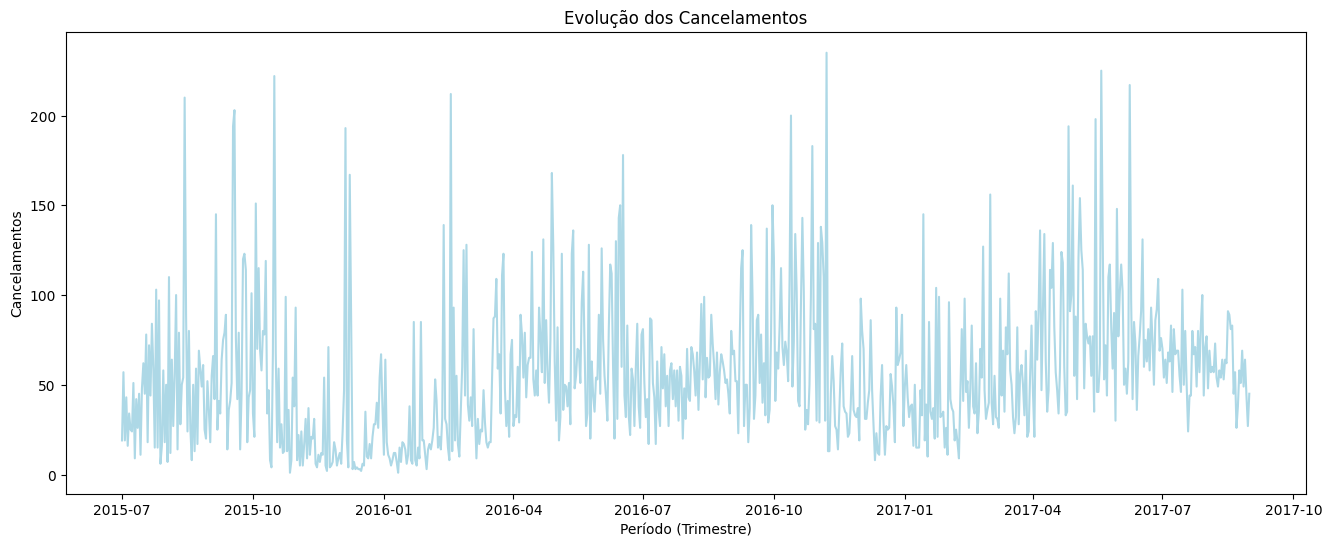

In [43]:
# Identificando evolução dos cancelamentos

df_plot = pd.DataFrame(df[df.cancellation==1].groupby(['arrival_date'])['cancellation'].count()).reset_index()

plt.figure(figsize=[16,6])
sns.lineplot(
    x='arrival_date',
    y='cancellation',
    data=df_plot,
    color='#ADD8E6')
plt.xlabel('Período (Trimestre)')
plt.ylabel('Cancelamentos')
plt.title('Evolução dos Cancelamentos')
plt.show()

del df_plot

Medindo pelos trimestres, podemos analisar que nao ha grande mudanca no comportamento das reservas. Isso pode se dar pelo periodo de férias na Europa e período mais comum de viagens, lembrando que a base se passa nos anos de 2015 a 2017, não havendo a grande incidencia de trabalho remoto que eixte hoje. Por isso considero o fator do comportamento parecido ao longo dos anos aos periodos de férias.

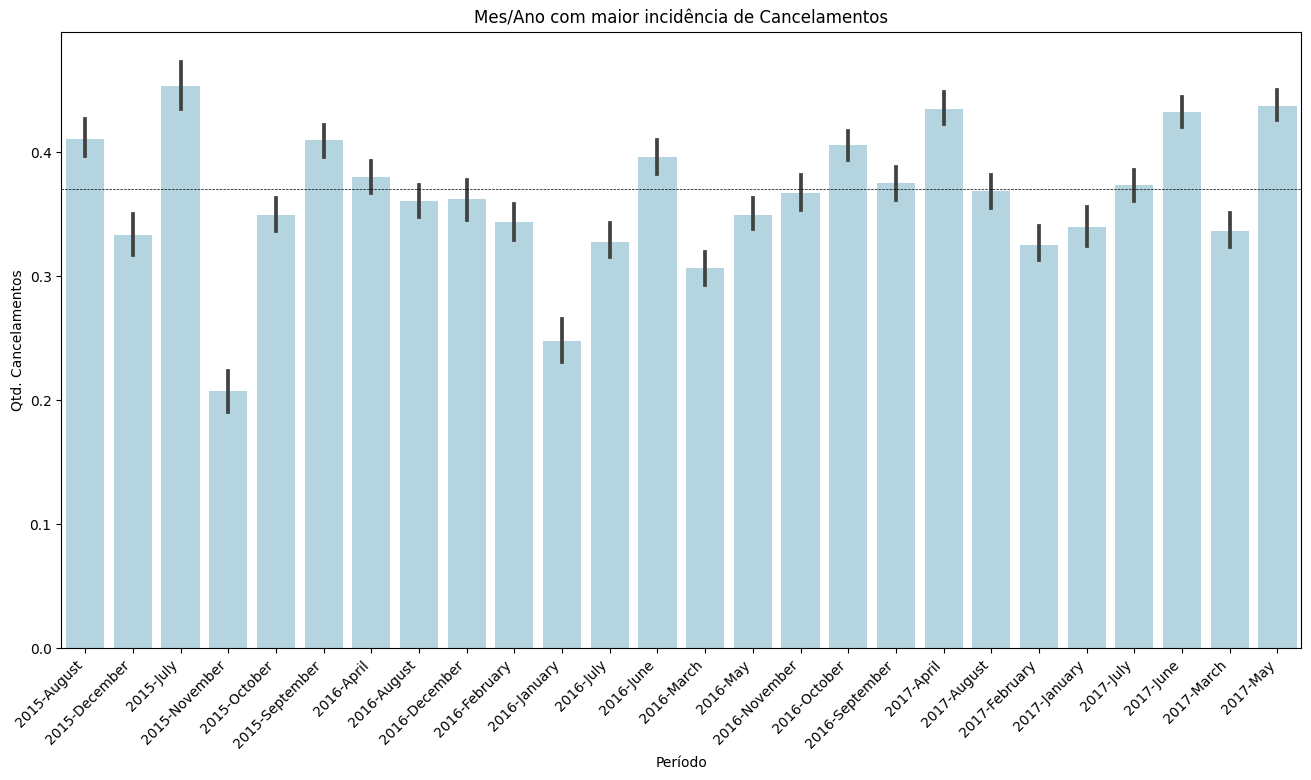

In [44]:
# Maiores meses com indice de cancelamento
# coluna 'year_month' combinando ano e mês
df['year_month'] = df['year_arrival_date'].astype(str) + '-' + df['month_arrival_date'].astype(str)

# Ordene o DataFrame por 'year_month'
df.sort_values(by='year_month', inplace=True)

plt.figure(figsize=[16,8])
sns.barplot(
    x='year_month',
    y='cancellation',
    data=df,
    color='#ADD8E6')
plt.axhline(np.mean(df.cancellation), c='black', lw=.5, ls='--', label='Média de Cancelamentos')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Período')
plt.ylabel('Qtd. Cancelamentos')
plt.title('Mes/Ano com maior incidência de Cancelamentos')
plt.show()
 

No período analisado acima, podemos ver que o comportamento tem pequenas variações. Nos meses em que podemos comparar pelos anos, temos uma variacao pequena em relacao aos cancelamentos. Vemos Agosto, por exemplo. Em 2015 teve mais cancelamento do que os dois anos subsequentes, que pelo tamanho da amostra, podemos dizer que ficaram muito próximos os numeros. Marco de 2016 e 2017 se mantiveram nos mesmos patamares. Carece de mais estudo sobre como estavam esses países nesses anos para entender melhor o comportamento dos dados.

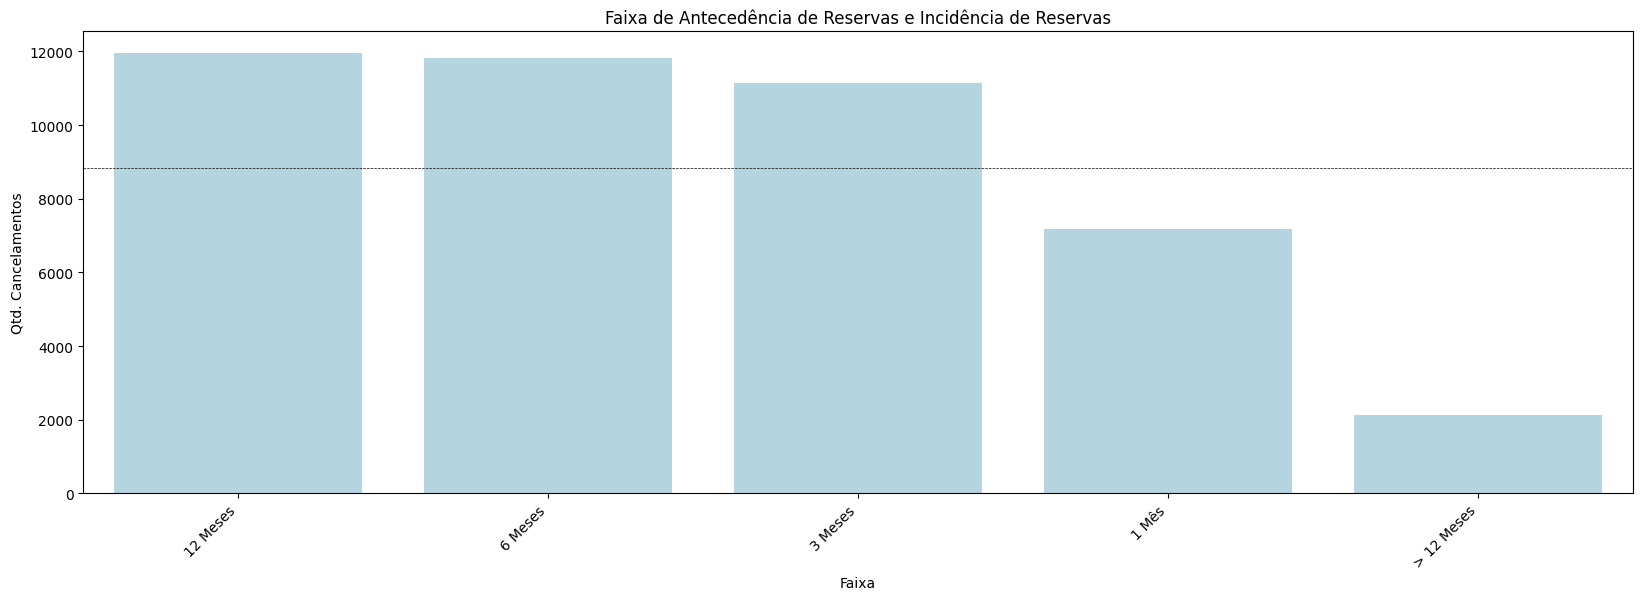

In [45]:
# Trabalhando com janelas de meses com maior incidencia de cancelamentos

df_plot = df[df.cancellation==1]
df_plot['faixa_dias_cancelamento'] = np.select([
    df_plot['days_between_booking_arrival'].between(0,30), # Reservas feitas com um mês de antecedência
    df_plot['days_between_booking_arrival'].between(31,90), # Reservas feitas com 3 meses de antecedência
    df_plot['days_between_booking_arrival'].between(91,180), # Reservas feitas com 6 meses de antecedência
    df_plot['days_between_booking_arrival'].between(181,365), # Reservas feitas com 12 meses de antecedência
    df_plot['days_between_booking_arrival'] > 365], # Reservas feitas com mais de um ano de antecedência
    ['1 Mês', '3 Meses', '6 Meses', '12 Meses', '> 12 Meses'])
df_plot = pd.DataFrame(df_plot.groupby(['faixa_dias_cancelamento'])['cancellation'].count()).reset_index()
df_plot.sort_values(by='cancellation', ascending=False, inplace=True)


plt.figure(figsize=[20,6])
sns.barplot(
    x='faixa_dias_cancelamento',
    y='cancellation',
    data=df_plot,
    color='#ADD8E6')
plt.axhline(np.mean(df_plot.cancellation), c='black', lw=.5, ls='--', label='Média de Cancelamentos')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Faixa')
plt.ylabel('Qtd. Cancelamentos')
plt.title('Faixa de Antecedência de Reservas e Incidência de Reservas')
plt.show()

del df_plot

Para perfilar os clientes que cancelam, podemos ver que no caso de um plano de ação p;ara reduzir os cancelamentos, deve-se focar no 3 primeiros períodos criticos: 1 ano, 6 meses e 3 meses. Ao comparar com o comportamento da base, vemos que pessoas que marcam com 1 mes de antecedencia e pessoas que planejam suas ferias a longo prazo (>12 meses) sao as que menos cancelam. Então viagens mais proximas e muito mais distantes dos dias de chegada sao as mais estaveis em relacao ao cancelamento.

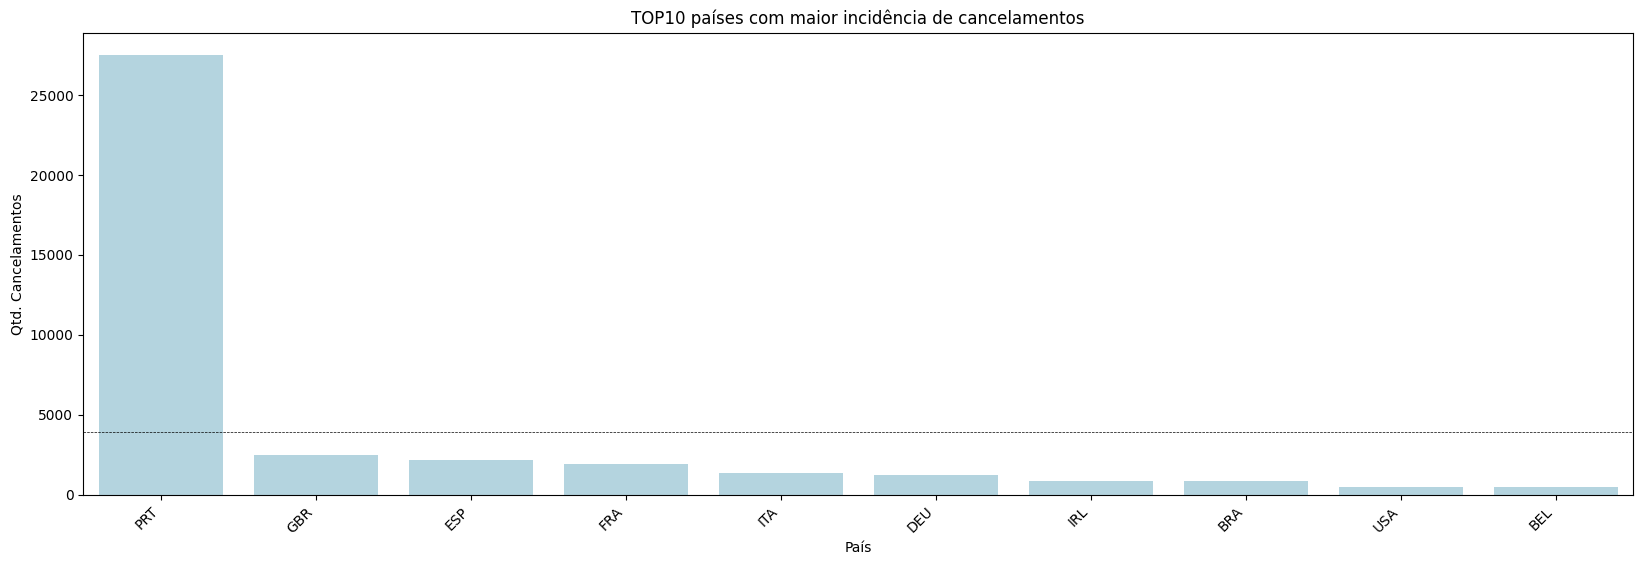

In [46]:
# Identificando meses com maior incidencia de cancelamentos

df_plot = pd.DataFrame(df[df.cancellation==1].groupby(['country'])['cancellation'].count()).reset_index()
df_plot.sort_values(by='cancellation', ascending=False, inplace=True)
df_plot = df_plot.head(10)

plt.figure(figsize=[20,6])
sns.barplot(
    x='country',
    y='cancellation',
    data=df_plot,
    color='#ADD8E6')
plt.axhline(np.mean(df_plot.cancellation), c='black', lw=.5, ls='--', label='Média de Cancelamentos')
plt.xticks(rotation=45, ha='right')
plt.xlabel('País')
plt.ylabel('Qtd. Cancelamentos')
plt.title('TOP10 países com maior incidência de cancelamentos')
plt.show()

del df_plot

Portugal é o país com maior índice de cancelamento. Comportando-se com um outlier na base, visto que todos os outros países tem índices muito próximos. No casode uma açao em cima disso, pode-se clusterizar a base toda e depois isolar portugal para ver as diferenças no comportamento desses países registrados.

#### 3. Criação e avaliação do modelo

In [47]:
def get_cols(df, target='cancellation', cols2exc=[]):
    '''
    Separa as features para normalização, enconding e target
    '''
    # features que passarão pelo enconding - objetos 
    cols2enc = [target] + [x for x in df.select_dtypes(include=['object']).columns if x not in cols2exc and x not in [target]]
    # features que serão normalizadas
    cols2norm = [x for x in df.select_dtypes(include=['int64', 'float64']).columns if x not in cols2exc and x not in cols2enc] 
        
    return cols2enc, cols2norm 

def normalizing(df, target='cancellation', cols2exc=[]):
    '''
    Aplica o enconding e normalização aos dados
    '''   
    # separate cols
    cols2enc, cols2norm = get_cols(df, target, cols2exc)
    #print(cols2enc, cols2norm)
    df_norm = pd.DataFrame()
    
    # encoding 
    enc_mapping = list()
    encoder = LabelEncoder()
    for col in cols2enc:
        encoded = encoder.fit_transform(df[col])#.astype(str))
        df_norm[col] = encoded
        mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
        enc_mapping.append([col, mapping])
        
    # normalizing
    scaler = MinMaxScaler()
    for col in cols2norm:
        encoded = scaler.fit_transform(df[col].astype(float).values.reshape(-1, 1))
        df_norm[col] = encoded
        
    return df_norm, enc_mapping

def get_model(X, y, nsplit=3, min_features=10, njobs=-1):
    '''
    Retorna o RFE + CV 
    '''
    rfc = RandomForestClassifier(random_state=42, class_weight='balanced')
    kfold = StratifiedKFold(n_splits=nsplit, shuffle=True) 
    cv = kfold.split(X, y)
    return RFECV(estimator=rfc, step=nsplit, min_features_to_select=min_features, cv=cv, n_jobs=njobs)

def get_features_info(rfecv, X, df, style=None):
    '''
    Retorna a análise das features selecionadas pelo RFECV + dataframe com essas features
    '''
    print('Número ótimo de variáveis selecionadas pelo RFE: {}'.format(rfecv.n_features_))
    
    if not style:
        style = {'font-family': 'manrope', 
                 'color-header': 'white',
                 'background-header': '#000000',
                 'header-fsize': '16px',
                 'background-even': '#7a7423',
                 'background-odd': '#a7e82b',
                 'rows-fsize' : '14px',
                 'figsize': (12,12),
                 'cmap': 'Greens',
                 'color': '#c04cfd'}
        
    # Visualizando as importancia das variáveis selecionadas
    X2 = X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1)
    dset = pd.DataFrame()
    dset['attr'] = X2.columns
    dset['importance'] = rfecv.estimator_.feature_importances_
    dset = dset.sort_values(by='importance', ascending=True)

    fig, axs = plt.subplots(2,1, figsize=style['figsize'], gridspec_kw={'height_ratios': [1, 3]})
    fig.suptitle('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold')
    axs[0].plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"], 
                color=style['color'], linewidth=3)
    axs[0].set_xlabel('Number of features selected', fontsize=14, labelpad=20)
    axs[0].set_ylabel('% Correct Classification', fontsize=14, labelpad=20)
    axs[1].barh(y=dset['attr'], width=dset['importance'], color=style['color'])
    axs[1].set_xlabel('Importancia', fontsize=14, labelpad=20)
    
    # Tabela com as variáveis e seu percentual de importancia
    df_import = pd.DataFrame(zip(dset.attr, [f'{x*100:.2f}%' for x in dset.importance.sort_values(ascending=True)]), columns=['Variável', 'Importancia'])
    print(df_import)

    # Variáveis selecionadas pelo RFE/RF
    cols_rfe = dset.attr
    # Dataframe com as features selecionadas 
    return df_import, df[cols_rfe.tolist()]

def work_model(model=None, ftype='pkl', path2save='../../models/', outname='model'):

    '''
    Salva ou carrega um modelo

    inputs:
    model = modelo a ser salvo
    ftype = tipo do arquivo, pkl ou joblib
    path2save = path para salvar/carregar o modelo: ex.: '../../models'
    outname = nome para o output - nome do modelo 

    output:
    retorna = arquivo salvo ou modelo carregado

    '''

    import os
    import joblib
    import pickle

    outname = os.path.join(path2save, outname)
    outfile = f"{outname}.{ftype}"

    if ftype == 'pkl':
        if model: # save
            pickle.dump(model, open(outfile, 'wb'))
            print(f'Model saved as {outfile}')  

        else: # load
            return pickle.load(open(f'{outfile}', 'rb'))

    else:
        if model:
            joblib.dump(model, outfile)
            print(f'Model saved as {outfile}')  

        else:
            return joblib.load(f'{outfile}')

def fit_model(X, y, model=LogisticRegression()):
    '''
    Fit modelos aos dados
    '''
    model.fit(X, y)
    return model

def model_metrics(X_test, y_test, model,  average_type='macro'):
    y = y_test
    y_pred = xgb.predict(X_test)

    model_metrics_dict = {'Acurácia': accuracy_score(y, y_pred),
                          'Precisão': precision_score(y, y_pred, average=average_type),
                          'Recall': recall_score(y, y_pred, average=average_type),
                              'F1-Score': f1_score(y, y_pred, average=average_type)}


    return model_metrics_dict

In [48]:
cols_exc = ['month_arrival_date','day_of_month_arrival_date', 'month_number_arrival_date']

df_norm, enc_mapping = normalizing(df, target='cancellation', cols2exc=cols_exc)

df_norm.to_csv('../../Dados/Intermediario/df_norm.csv', sep=';', index=False)

In [49]:
# Inserindo variáveis NOISE e separando features do target

cols2exc=[]
target = ['cancellation']

# Insere noise
df_norm['NOISE1'] = np.random.normal(0, 1, df_norm.shape[0])
df_norm['NOISE2'] = np.random.rand(df_norm.shape[0])

X = df_norm.drop(cols2exc+target, axis=1) # Features
y = df_norm[target[0]].values # Target

A técnica disposta acima se chama RANDOM BAR. O Random Bar é uma técnica de seleção de características no Aprendizado de Máquina que envolve a adição de uma variável aleatória a um conjunto de características existente. Um algoritmo de Aprendizado Supervisionado é treinado usando uma medida de erro para identificar as características relevantes, descartando aquelas com importância inferior à aleatória. Isso é útil para eliminar rapidamente características desnecessárias, mesmo em grandes conjuntos de dados, e pode ser aplicado a dados não lineares. ​

In [50]:
# Catboost classifier
from catboost import CatBoostClassifier, Pool
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    random_state=42,
    early_stopping_rounds=100,
    posterior_sampling=True,
    loss_function="Logloss",
    eval_metric="AUC",
    metric_period=100,
)

# Selecione as features
selected_features = model.select_features(
    X=X,
    y=y,
    features_for_select=X.columns,
    num_features_to_select= 15, 
    algorithm="RecursiveByShapValues",
    steps=7,
    train_final_model=False,
    verbose=False,
)

Step #1 out of 7
Feature #15 eliminated
Feature #14 eliminated
Step #2 out of 7
Feature #24 eliminated
Feature #11 eliminated
Step #3 out of 7
Feature #23 eliminated
Feature #13 eliminated
Step #4 out of 7
Feature #12 eliminated
Feature #1 eliminated
Step #5 out of 7
Feature #4 eliminated
Step #6 out of 7
Feature #26 eliminated
Feature #25 eliminated
Step #7 out of 7
Feature #5 eliminated


O seletor de features que costumo usar para problemas de classificação é o CaBoost Classifier. É um ótimo algoritmo para lidar com problemas diversos de classificação. A quantidade de features é arbitrário, sendo uma escolha minha.

In [51]:
index = list(selected_features.get('selected_features'))
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    random_state=42,
    early_stopping_rounds=100,
    posterior_sampling=True,
    loss_function="Logloss",
    eval_metric="AUC",
    metric_period=100,
)

index_att = list(np.sort((index)))
index_att

[0, 2, 3, 6, 7, 8, 9, 10, 16, 17, 18, 19, 20, 21, 22]

In [54]:
model.fit(X.iloc[:, index_att],y, verbose = False)

In [53]:
feature_importance = model.get_feature_importance(data=Pool(X.iloc[:, index_att], label=y), type="LossFunctionChange")
feature_importance = feature_importance.reshape(-1,1)
feature_importance = feature_importance[feature_importance > 0]* 100 
feature_importance

array([ 0.23872714, 10.3420613 ,  3.29248136,  2.69913849,  1.11582191,
        0.92249473,  4.27031868,  0.77464528,  1.63980106,  0.41945669,
        0.70504698,  1.20454622,  1.66753861,  4.23754114,  0.39069741])

In [55]:
feature_importance_df = pd.DataFrame({
    'Feature': X.iloc[:,index_att].columns,
    'Importance': feature_importance
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)
feature_importance_df = feature_importance_df[feature_importance_df['Feature'] != 'NOISE1']
feature_importance_df

,Feature,Importance
0,type,0.238727
14,total_nights,0.390697
9,num_previous_stays,0.419457
10,changes_between_booking_arrival,0.705047
7,week_number_arrival_date,0.774645
5,year_month,0.922495
4,customer_type,1.115822
11,avg_price,1.204546
8,num_previous_cancellations,1.639801
12,required_car_parking_spaces,1.667539


In [56]:
feature_clean = feature_importance_df['Feature']
feature_clean_list = feature_clean.tolist()

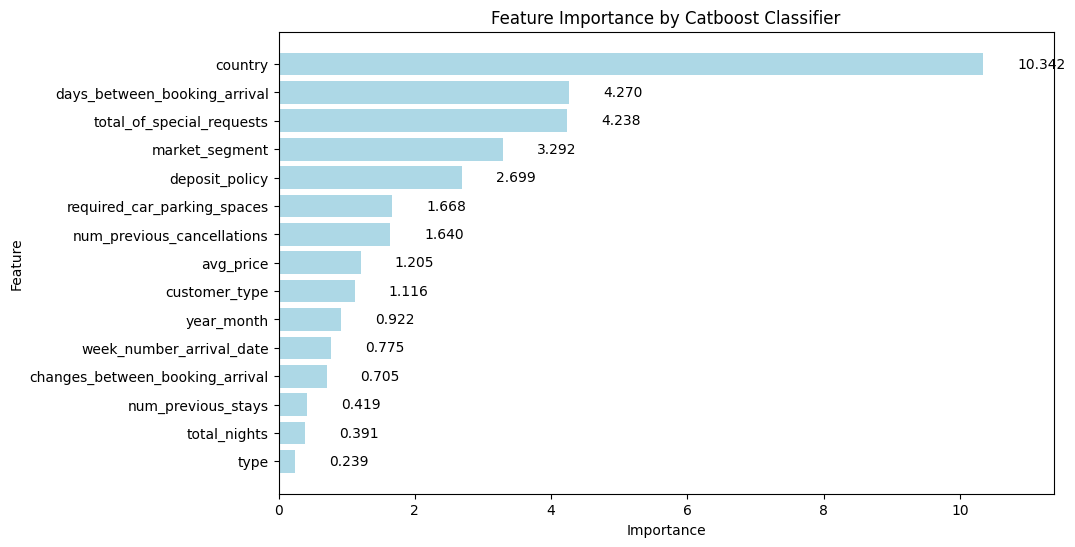

In [57]:
# Plotando o gráfico de barras horizontais
plt.figure(figsize=(10, 6))
bars = plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='#ADD8E6')

# Adicionando valores acima das barras
for bar in bars:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.3f}', va='center')

# Configurações do gráfico
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance by Catboost Classifier')
plt.xlim(0, max(feature_importance_df['Importance']) * 1.1)  # Definindo limites do eixo x

# Mostrando o gráfico
plt.show()

Pode-se ver que aqui as variáveis NOISE nao apareceram, o que significa que nao será necessário excluir nenhuma variável das escolhidas para o modelo. A variável país foi a mais importante, tendo o total de convidados especiais em segundo lugar e os dias entre o agendamento e a chegada em terceiro. Faz sentido. Como vimos, os dias entre o agendamento e a chegada sao importantes na decisao do cancelamento, o pais (especialmente por PT) também e o total de special requests que gira em torno de tipo de cama, etc, traz uma informação sobre quantas pessoas estarão naquele quarto. Quando você marca uma viagem e está acompanhado, os pesos de decisão são diferentes de quando você está sozinho. O Impacto pode ser medido dessa maneira. Fonte para o dic de dados: https://www.sciencedirect.com/science/article/pii/S2352340918315191

In [58]:
# Função que Salva ou carrega um modelo (ftype = tipo do arquivo, pkl ou joblib)
def work_model(model=None, ftype='pkl', path2save='../../models/', outname='model'):
    '''
    Salva ou carrega um modelo

    inputs:
    model = modelo a ser salvo
    ftype = tipo do arquivo, pkl ou joblib
    path2save = path para salvar/carregar o modelo: ex.: '../../models' 
    outname = nome para o output - nome do modelo

    output:
    retorna = arquivo salvo ou modelo carregado
    '''
    import os
    import joblib
    import pickle
    
    outname = os.path.join(path2save, outname) 
    outfile = f"{outname}.{ftype}" 
    if ftype == 'pkl':
        if model: # save
            pickle.dump(model, open(outfile, 'wb'))
            print(f'Model saved as {outfile}')   
        else: # load
            return pickle.load(open(f'{outfile}', 'rb'))
    else:
        if model:
            joblib.dump(model, outfile)
            print(f'Model saved as {outfile}')   
        else:
            return joblib.load(f'{outfile}')
        
# Parametros
def grid_search(X, y, model=LogisticRegression(), nsplit=3, param_grid={}, average_type='macro', njobs=-1):
    '''
    Executa o grid search
    '''
    kfold = StratifiedKFold(n_splits=nsplit, shuffle=True) 
    cv = kfold.split(X, y) 
    score = make_scorer(f1_score, average=average_type, greater_is_better=True)
    clf = GridSearchCV(model, param_grid, scoring=score, cv=cv, n_jobs=njobs)
    clf.fit(X, y)
    print('F1 score: ', clf.best_score_)
    print('Best parameters: ', clf.best_params_)
    return clf.cv_results_['mean_test_score']

def fit_model(X, y, model=LogisticRegression()):
    '''
    Fit modelos aos dados
    '''
    model.fit(X, y)
    return model

def eval_model(model, X, y, average_type='macro', labels=None, target_names=None):
    '''
    Retorna as metricas básicas de acordo com a predição
    '''
    y_pred = model.predict(X)
    #auc_scores = roc_auc_score(y, model.predict_proba(X))  #multi_class='ovr', average=None)
    class_order = [int(model.classes_[i]) for i in labels]
    #score_order = [auc_scores[n] for n in class_order]
    #aucs = [f'class {x}: {val:.2%}' for x, val in zip(target_names,score_order)]
    print('Report: \n', classification_report(y, y_pred, labels=labels, target_names=target_names))
    print('Accuracy: %.3f' % (accuracy_score(y, y_pred)))
    print('Precision: %.3f' % (precision_score(y, y_pred, average=average_type)))
    print('Recall: %.3f' % (recall_score(y, y_pred, average=average_type)))
    print('F1 score: %.3f' % (f1_score(y, y_pred, average=average_type)))
    #print('AUC scores for each class using One-vs-rest: \n', aucs)

def plot_conf_matrix(model, X_train, X_test, y_test, y_train,
                     eval_mode='ovr',
                     average_type='macro',
                     cmap_='Greens',
                     labels_order=None,
                     target_names=None,
                     tick_marks=None):
    
    y_pred_trainp = model.predict_proba(X_train)
    y_predp = model.predict_proba(X_test)
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    roc_test = roc_auc_score(y_test, y_pred)
    print(f'ROC_AUC score test: {roc_test*100:.2f}%')

    
    conf_matrix = confusion_matrix(y_test, y_pred, labels=labels_order)
    print('Confusion matrix for test: \n')
    group_counts = ['{0:0.0f}'.format(value) for value in conf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
    annot_ = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]
    annot_ = np.asarray(annot_).reshape(conf_matrix.shape)   
    sns.heatmap(conf_matrix, annot=annot_, fmt='', xticklabels=target_names, yticklabels=target_names, cmap=cmap_)

def eval_model_all(model, X, y, X_train, X_test, y_train, y_test, eval_mode='ovr', average_type='macro', cmap_='Greens', labels_order=None, target_names=None, tick_marks=None):
    '''
    Retorna todas as principais metricas levando em consideração dos os dados
    '''

    y_pred_trainp = model.predict_proba(X_train)
    y_predp = model.predict_proba(X_test) 
    y_allp = model.predict_proba(X)

    roc_train = roc_auc_score(y_train, y_pred_trainp) # multi_class=eval_mode)  
    roc_test = roc_auc_score(y_test, y_predp)# multi_class=eval_mode)
    roc_all = roc_auc_score(y, y_allp) #multi_class=eval_mode)
    print(f'ROC_AUC score train: {roc_train*100:.2f}%')
    print(f'ROC_AUC score test: {roc_test*100:.2f}%')
    print(f'ROC_AUC score all: {roc_all*100:.2f}% \n')
    
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)
    y_pall = model.predict(X)
    
    print(f'Accuracy for train: {accuracy_score(y_train, y_pred_train)*100:.2f}%')
    print(f'Accuracy for test: {accuracy_score(y_test, y_pred)*100:.2f}%')
    print(f'Accuracy for all: {accuracy_score(y,y_pall)*100:.2f}% \n')
    
    sen_train = sensitivity_score(y_train, y_pred_train, average=average_type)
    sen_test = sensitivity_score(y_test, y_pred, average=average_type)
    sen_all = sensitivity_score(y, y_pall, average=average_type)
    spe_train = specificity_score(y_train, y_pred_train, average=average_type)
    spe_test = specificity_score(y_test, y_pred, average=average_type)
    spe_all = specificity_score(y, y_pall, average=average_type)
    print(f'Sensitivity for train: {sen_train*100:.2f}%, Specificity for train: {spe_train*100:.2f}')
    print(f'Sensitivity for test: {sen_test*100:.2f}%, Specificity for test: {spe_test*100:.2f}')
    print(f'Sensitivity for all: {sen_all*100:.2f}%, Specificity for all: {spe_all*100:.2f} \n')
                
    conf_matrix = confusion_matrix(y_test, y_pred, labels=labels_order)
    print('Confusion matrix for test: \n')
    group_counts = ['{0:0.0f}'.format(value) for value in conf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
    annot_ = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]
    annot_ = np.asarray(annot_).reshape(conf_matrix.shape)   
    sns.heatmap(conf_matrix, annot=annot_, fmt='', xticklabels=target_names, yticklabels=target_names, cmap=cmap_)



In [59]:
variaveis_selecionadas = list(feature_importance_df.Feature) 
variaveis_selecionadas

['type',
 'total_nights',
 'num_previous_stays',
 'changes_between_booking_arrival',
 'week_number_arrival_date',
 'year_month',
 'customer_type',
 'avg_price',
 'num_previous_cancellations',
 'required_car_parking_spaces',
 'deposit_policy',
 'market_segment',
 'total_of_special_requests',
 'days_between_booking_arrival',
 'country']

In [60]:
# ajustando o df do modelo
df_rfe = df_norm[variaveis_selecionadas]
df_rfe['cancellation'] = df_norm['cancellation']
df_rfe

,type,total_nights,num_previous_stays,changes_between_booking_arrival,week_number_arrival_date,year_month,customer_type,avg_price,num_previous_cancellations,required_car_parking_spaces,deposit_policy,market_segment,total_of_special_requests,days_between_booking_arrival,country,cancellation
0,1,0.086957,0.0,0.0,0.634615,0,0,0.250,0.0,0.0,0,0,0.0,0.018996,123,0
1,1,0.043478,0.0,0.0,0.673077,0,0,0.300,0.0,0.0,1,5,0.0,0.141113,51,1
2,1,0.043478,0.0,0.0,0.673077,0,0,0.300,0.0,0.0,1,5,0.0,0.141113,51,1
3,1,0.043478,0.0,0.0,0.673077,0,0,0.300,0.0,0.0,1,5,0.0,0.141113,51,1
4,1,0.043478,0.0,0.0,0.673077,0,0,0.300,0.0,0.0,1,5,0.0,0.141113,51,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,1,0.043478,0.0,0.0,0.365385,25,0,0.366,0.0,0.0,0,2,0.4,0.434193,154,1
119386,1,0.043478,0.0,0.0,0.365385,25,0,0.480,0.0,0.0,0,2,0.0,0.146540,25,1
119387,1,0.028986,0.0,0.0,0.365385,25,2,0.297,0.0,0.0,0,3,0.0,0.423338,135,1
119388,1,0.043478,0.0,0.0,0.365385,25,0,0.462,0.0,0.0,0,2,0.4,0.246947,25,1


In [62]:
#separar a base de validação 

df_validation = shap.sample(df_rfe, nsamples= int(df_rfe.shape[0]* 0.20))
X_val = df_validation.drop('cancellation', axis = 1)
y_val = df_validation.cancellation

#retirar os dados da validação da base principal

df_rfe = df_rfe.drop(df_validation.index)
df_rfe

,type,total_nights,num_previous_stays,changes_between_booking_arrival,week_number_arrival_date,year_month,customer_type,avg_price,num_previous_cancellations,required_car_parking_spaces,deposit_policy,market_segment,total_of_special_requests,days_between_booking_arrival,country,cancellation
0,1,0.086957,0.0,0.0,0.634615,0,0,0.250,0.0,0.0,0,0,0.0,0.018996,123,0
1,1,0.043478,0.0,0.0,0.673077,0,0,0.300,0.0,0.0,1,5,0.0,0.141113,51,1
2,1,0.043478,0.0,0.0,0.673077,0,0,0.300,0.0,0.0,1,5,0.0,0.141113,51,1
5,1,0.043478,0.0,0.0,0.673077,0,0,0.300,0.0,0.0,1,5,0.0,0.141113,51,1
7,1,0.043478,0.0,0.0,0.673077,0,0,0.300,0.0,0.0,1,5,0.0,0.141113,51,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119383,1,0.043478,0.0,0.0,0.365385,25,0,0.420,0.0,0.0,0,2,0.2,0.101764,76,1
119384,1,0.014493,0.0,0.0,0.326923,25,0,0.390,0.0,0.0,0,0,0.2,0.025780,43,0
119386,1,0.043478,0.0,0.0,0.365385,25,0,0.480,0.0,0.0,0,2,0.0,0.146540,25,1
119387,1,0.028986,0.0,0.0,0.365385,25,2,0.297,0.0,0.0,0,3,0.0,0.423338,135,1


<AxesSubplot: title={'center': 'Test sample'}, ylabel='count'>

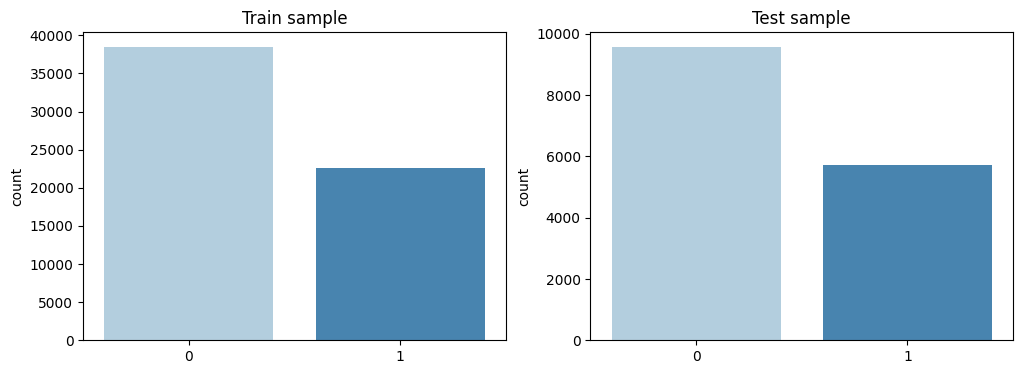

In [63]:
# Separa as features
cols2exc = []
target = ['cancellation']

X = df_rfe.drop(cols2exc + target, axis=1) # features
y = df_rfe[target[0]].values # target

# Divide os dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# check da distribuição dos targets
fig, axs = plt.subplots(1,2, figsize=[12,4])
axs[0].title.set_text("Train sample")
sns.countplot(x=y_train, ax=axs[0], palette='Blues')
axs[1].title.set_text("Test sample")
sns.countplot(x=y_test, ax=axs[1], palette='Blues')

In [64]:
# retirando a coluna NOISE1 do teste tambem.
coluna_a_remover = 'NOISE1'

if coluna_a_remover in X_test.columns:
    X_test = X_test.drop(coluna_a_remover, axis=1)

In [65]:
class_validation = pd.DataFrame(pd.DataFrame(y_train).value_counts(normalize = True).mul(100).round(2))
class_validation # verifica a proporcao das classes entre sim (1) ou nao (0)

,proportion
0,
0,62.93
1,37.07


As classes estao relativamente desbalanceadas. Num modelo com mais tempo de producao, testaria fazer um from imblearn.under_sampling import RandomUnderSampler para balancear as classes com um undersampling e testaria ambos, para comparar.


In [68]:
# otimizando com Optuna
def objective(trial):
    # Definição do espaço de busca para os hiperparâmetros
    param_dist = {
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 5, 50),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample']),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    }

    # Instância do classificador com os hiperparâmetros sugeridos
    clf = XGBClassifier(random_state=42, n_jobs=-1, **param_dist)

    # Avaliação do desempenho do modelo usando validação cruzada
    score = cross_val_score(clf, X_train, y_train, cv=3, n_jobs=-1).mean()

    return -score  # Objetivo é minimizar o erro, por isso usamos o negativo do score

# Criando um estudo Optuna
study = optuna.create_study(direction='maximize')  # 'maximize' para maximizar o score

# Otimização de hiperparâmetros
study.optimize(objective, n_trials=50)  # Ajuste o número de trials conforme necessário

# Melhores hiperparâmetros
best_params = study.best_params

print("Melhores hiperparâmetros:", best_params)

[I 2023-10-01 18:53:39,865] A new study created in memory with name: no-name-b8bd1574-4456-46a9-921a-6140896765b6
[I 2023-10-01 18:54:16,568] Trial 0 finished with value: -0.8672621384635519 and parameters: {'max_features': 'log2', 'max_depth': 44, 'min_samples_split': 27, 'class_weight': None, 'criterion': 'entropy'}. Best is trial 0 with value: -0.8672621384635519.
[I 2023-10-01 18:54:26,721] Trial 1 finished with value: -0.8666404920821882 and parameters: {'max_features': 'log2', 'max_depth': 9, 'min_samples_split': 22, 'class_weight': 'balanced_subsample', 'criterion': 'log_loss'}. Best is trial 1 with value: -0.8666404920821882.
[I 2023-10-01 18:54:35,599] Trial 2 finished with value: -0.8666404920821882 and parameters: {'max_features': 'log2', 'max_depth': 9, 'min_samples_split': 24, 'class_weight': 'balanced_subsample', 'criterion': 'log_loss'}. Best is trial 1 with value: -0.8666404920821882.
[I 2023-10-01 18:55:04,279] Trial 3 finished with value: -0.8669840335034681 and param

Melhores hiperparâmetros: {'max_features': 'sqrt', 'max_depth': 5, 'min_samples_split': 35, 'class_weight': 'balanced', 'criterion': 'entropy'}


In [69]:
params = study.best_params
params

{'max_features': 'sqrt',
 'max_depth': 5,
 'min_samples_split': 35,
 'class_weight': 'balanced',
 'criterion': 'entropy'}

In [71]:
final_model = XGBClassifier(learning_rate=0.5,
                           max_depth=10,
                           min_child_weight=5,
                           n_estimators=100,
                            verbosity=0)

xgb = fit_model(X_train, y_train, model = final_model)
# avaliando a saida do modelo
eval_model(xgb, X_test, y_test, labels=[0,1], target_names=['booked','cancellation'])

Report: 
               precision    recall  f1-score   support

      booked       0.88      0.91      0.89      9568
cancellation       0.84      0.79      0.82      5714

    accuracy                           0.87     15282
   macro avg       0.86      0.85      0.86     15282
weighted avg       0.87      0.87      0.87     15282

Accuracy: 0.866
Precision: 0.860
Recall: 0.852
F1 score: 0.856


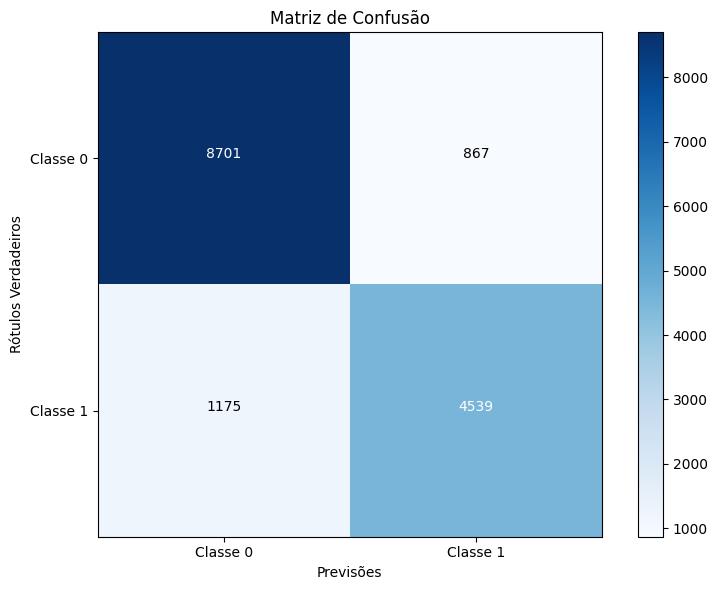

In [72]:
# Calcular a matriz de confusão
y_pred = xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.colorbar()
tick_marks = [0, 1]
plt.xticks(tick_marks, ['Classe 0', 'Classe 1'])
plt.yticks(tick_marks, ['Classe 0', 'Classe 1'])
plt.xlabel('Previsões')
plt.ylabel('Rótulos Verdadeiros')

# Adicione os valores dentro das células da matriz
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


In [81]:
#explainer dash do primeiro modelo (acesse o doc)

explainer = ClassifierExplainer(xgb, X_test, y_test)
ExplainerDashboard(explainer).run()

Detected XGBClassifier model: Changing class type to XGBClassifierExplainer...
Note: model_output=='probability'. For XGBClassifier shap values normally get calculated against X_background, but paramater X_background=None, so using X instead
Generating self.shap_explainer = shap.TreeExplainer(model, X, model_output='probability', feature_perturbation='interventional')...
Note: Shap interaction values will not be available. If shap values in probability space are not necessary you can pass model_output='logodds' to get shap values in logodds without the need for a background dataset and also working shap interaction values...
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
Generating layout...
Calculating shap values...


 99%|===================| 15162/15282 [01:27<00:00]        

Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Generating xgboost model dump...
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating predictions...
Calculating pred_percentiles...
Calculating ShadowDecTree for each individual decision tree...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://192.168.31.62:8050


ConnectionError: HTTPConnectionPool(host='0.0.0.0', port=8050): Max retries exceeded with url: /_alive_1a6ea05d-59b0-4563-bb45-3ec7fae2a24a (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x00000144EF1EB2B0>: Failed to establish a new connection: [WinError 10049] O endereço solicitado não é válido no contexto'))

<strong> Precision: </strong> A precisão é a proporção de exemplos classificados como positivos pelo modelo que são realmente positivos. No contexto deste problema, a precisão para a classe "booked" é de 0.88 e para a classe "cancellation" é de 0.84. Isso significa que 89% das reservas previstas como reservas realmente eram reservas, e 84% das cancelamentos previstos como cancelamentos realmente eram cancelamentos. A precisão mede a capacidade do modelo de evitar falsos positivos. </br>

<strong>Recall:</strong> O recall é a proporção de exemplos positivos reais que foram corretamente identificados pelo modelo. Para a classe "booked", o recall é de 0,91, o que significa que o modelo capturou 91% das reservas reais. Para a classe "cancellation", o recall é de 0,79, o que indica que o modelo identificou corretamente 79% dos cancelamentos reais. A revocação mede a capacidade do modelo de evitar falsos negativos.</br>

<strong>F1-Score:</strong> O F1-Score é a média harmônica da Precision e da Recall. Para a classe "booked", o F1-Score é de 0.89, e para a classe "cancellation", o F1-Score é de 0.82. Um F1-Score mais alto indica um equilíbrio melhor entre Precision e Recall.</br>

<strong>Support:</strong> É o número de exemplos reais de cada classe no conjunto de dados. Para a classe "booked", há 9568 exemplos reais, e para a classe "cancellation", há 5714 exemplos reais.</br>

<strong>Acurácia:</strong> A acurácia é a proporção de exemplos classificados corretamente pelo modelo em relação ao total de exemplos. Neste caso, a acurácia é de 0.866, o que significa que o modelo classificou corretamente 86% de todos os exemplos.</br>

Pode-se avaliar que as métreicas atingidas pelo modelo estão muito boas. 

#### 4. Modelo utilizando os anos como divisão

Premissas:</br>

Base de treino -> Anos de 2015 e 2016</br>
Base de teste -> Ano de 2017</br>


In [73]:
# trazendo de volta a coluna year_arrival_date para que eu possa fazer a selecao por ano, conforme enunciado + as colunas selecionadas para o primeiro mnodelo pelo catbopost classifier
df_rfe_yo = df_norm[[
 'year_arrival_date',
 'num_previous_stays',
 'total_nights',
 'changes_between_booking_arrival',
 'week_number_arrival_date',
 'avg_price',
 'year_month',
 'customer_type',
 'required_car_parking_spaces',
 'num_previous_cancellations',
 'deposit_policy',
 'market_segment',
 'days_between_booking_arrival',
 'total_of_special_requests',
 'country']]
df_rfe_yo['cancellation'] = df_norm['cancellation']
df_rfe_yo

,year_arrival_date,num_previous_stays,total_nights,changes_between_booking_arrival,week_number_arrival_date,avg_price,year_month,customer_type,required_car_parking_spaces,num_previous_cancellations,deposit_policy,market_segment,days_between_booking_arrival,total_of_special_requests,country,cancellation
0,0,0.0,0.086957,0.0,0.634615,0.250,0,0,0.0,0.0,0,0,0.018996,0.0,123,0
1,0,0.0,0.043478,0.0,0.673077,0.300,0,0,0.0,0.0,1,5,0.141113,0.0,51,1
2,0,0.0,0.043478,0.0,0.673077,0.300,0,0,0.0,0.0,1,5,0.141113,0.0,51,1
3,0,0.0,0.043478,0.0,0.673077,0.300,0,0,0.0,0.0,1,5,0.141113,0.0,51,1
4,0,0.0,0.043478,0.0,0.673077,0.300,0,0,0.0,0.0,1,5,0.141113,0.0,51,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,2,0.0,0.043478,0.0,0.365385,0.366,25,0,0.0,0.0,0,2,0.434193,0.4,154,1
119386,2,0.0,0.043478,0.0,0.365385,0.480,25,0,0.0,0.0,0,2,0.146540,0.0,25,1
119387,2,0.0,0.028986,0.0,0.365385,0.297,25,2,0.0,0.0,0,3,0.423338,0.0,135,1
119388,2,0.0,0.043478,0.0,0.365385,0.462,25,0,0.0,0.0,0,2,0.246947,0.4,25,1


<AxesSubplot: title={'center': 'Test Sample'}, xlabel='cancellation', ylabel='count'>

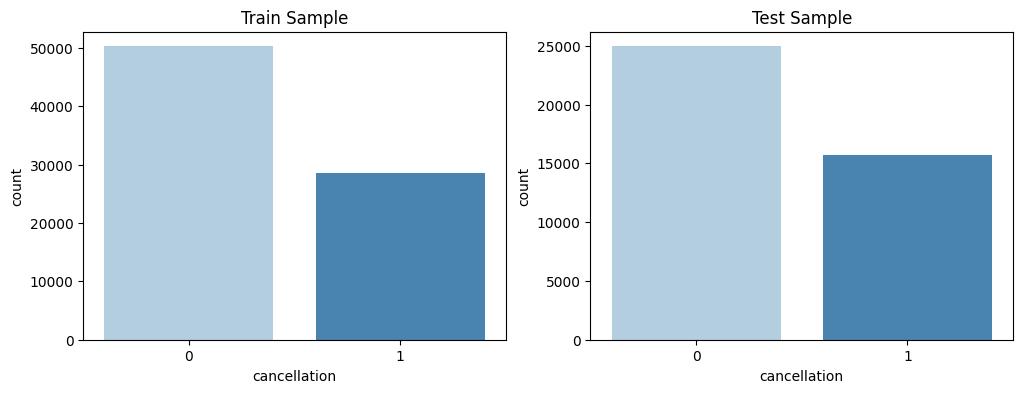

In [74]:
# Os valores referentes aos anos colocados nos filtros foram obtidos no encoding map (enc_mapping)
# mapping para o ano -> ['year_arrival_date', {'2015': 0, '2016': 1, '2017': 2}]
X_train_yo = df_rfe_yo[df_rfe_yo.year_arrival_date.isin([0,1])].drop(columns=['year_arrival_date','cancellation'])
X_test_yo = df_rfe_yo[df_rfe_yo.year_arrival_date==2].drop(columns=['year_arrival_date','cancellation'])

y_train_yo = df_rfe_yo[df_rfe_yo.year_arrival_date.isin([0,1])].cancellation
y_test_yo = df_rfe_yo[df_rfe_yo.year_arrival_date==2].cancellation

# Check da distribuição do target
fig, axs = plt.subplots(1,2, figsize=[12,4])
axs[0].title.set_text('Train Sample')
sns.countplot(x=y_train_yo, ax=axs[0], palette='Blues')
axs[1].title.set_text('Test Sample')
sns.countplot(x=y_test_yo, ax=axs[1], palette='Blues')

In [75]:
# Função de objetivo para otimização com Optuna
def objective(trial):
    # Definição do espaço de busca para os hiperparâmetros
    param_dist = {
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 5, 50),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample']),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    }

    # Instância do classificador com os hiperparâmetros sugeridos
    clf = XGBClassifier(random_state=42, n_jobs=-1, **param_dist)

    # Avaliação do desempenho do modelo usando validação cruzada
    score = cross_val_score(clf, X_train_yo, y_train_yo, cv=3, n_jobs=-1).mean()

    return -score  # Objetivo é minimizar o erro, por isso usamos o negativo do score

# Criando um estudo Optuna
study_yo = optuna.create_study(direction='maximize')  # 'maximize' para maximizar o score

# Otimização de hiperparâmetros
study_yo.optimize(objective, n_trials=50)  # Ajuste o número de trials conforme necessário

# Melhores hiperparâmetros
best_params = study_yo.best_params

print("Melhores hiperparâmetros:", best_params)

[I 2023-10-01 19:11:13,276] A new study created in memory with name: no-name-18d81f24-edcd-45b6-9bf2-1d417e01035a
[I 2023-10-01 19:11:42,262] Trial 0 finished with value: -0.8256738214271359 and parameters: {'max_features': 'log2', 'max_depth': 39, 'min_samples_split': 16, 'class_weight': 'balanced_subsample', 'criterion': 'entropy'}. Best is trial 0 with value: -0.8256738214271359.
[I 2023-10-01 19:11:52,642] Trial 1 finished with value: -0.8140859632790743 and parameters: {'max_features': 'sqrt', 'max_depth': 12, 'min_samples_split': 40, 'class_weight': 'balanced_subsample', 'criterion': 'gini'}. Best is trial 1 with value: -0.8140859632790743.
[I 2023-10-01 19:12:30,344] Trial 2 finished with value: -0.8249876855370806 and parameters: {'max_features': 'log2', 'max_depth': 49, 'min_samples_split': 21, 'class_weight': None, 'criterion': 'log_loss'}. Best is trial 1 with value: -0.8140859632790743.
[I 2023-10-01 19:13:03,743] Trial 3 finished with value: -0.8215062410286524 and paramet

Melhores hiperparâmetros: {'max_features': 'sqrt', 'max_depth': 5, 'min_samples_split': 24, 'class_weight': None, 'criterion': 'gini'}


In [76]:
# Avaliação do modelo XGBoost com os parametros otimizados com o Optuna
rfc_yo_params = study_yo.best_params
rfc_yo_params['n_jobs'] = -1
rfc_yo_params['random_state'] = 42

rfc_yo = fit_model(X_train_yo, y_train_yo, model=XGBClassifier(**rfc_yo_params))
y_pred_yo = rfc_yo.predict(X_test_yo)

[19:23:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "criterion", "max_features", "min_samples_split" } are not used.



In [80]:
# explainer modelo 2
explainer_2 = ClassifierExplainer(rfc_yo, X_test_yo, y_test_yo)
ExplainerDashboard(explainer_2).run()

Detected XGBClassifier model: Changing class type to XGBClassifierExplainer...


Note: model_output=='probability'. For XGBClassifier shap values normally get calculated against X_background, but paramater X_background=None, so using X instead
Generating self.shap_explainer = shap.TreeExplainer(model, X, model_output='probability', feature_perturbation='interventional')...
Note: Shap interaction values will not be available. If shap values in probability space are not necessary you can pass model_output='logodds' to get shap values in logodds without the need for a background dataset and also working shap interaction values...
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
Generating layout...
Calculating shap values...


100%|===================| 40627/40687 [01:05<00:00]        

Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Generating xgboost model dump...
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating predictions...
Calculating pred_percentiles...
Calculating ShadowDecTree for each individual decision tree...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://192.168.31.62:8050


ConnectionError: HTTPConnectionPool(host='0.0.0.0', port=8050): Max retries exceeded with url: /_alive_1a6ea05d-59b0-4563-bb45-3ec7fae2a24a (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000014492CE45E0>: Failed to establish a new connection: [WinError 10049] O endereço solicitado não é válido no contexto'))

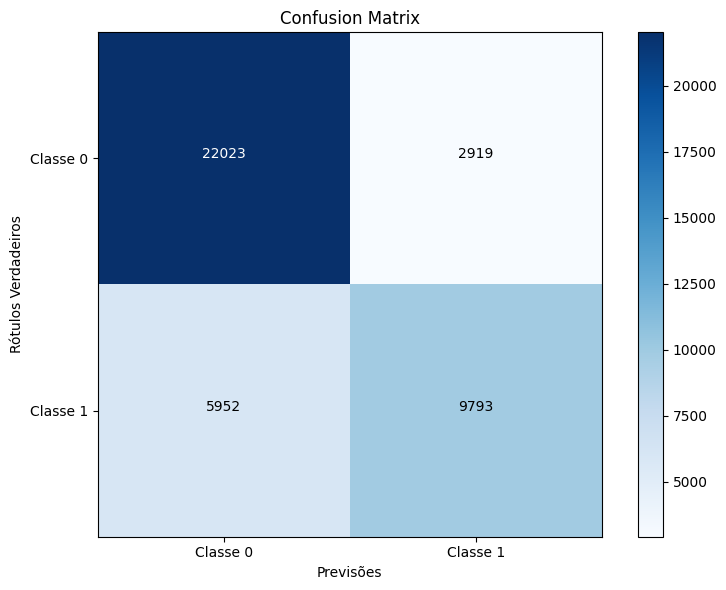

In [ ]:

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
# Calcular a matriz de confusão
cm = confusion_matrix(y_test_yo, y_pred_yo)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = [0, 1]
plt.xticks(tick_marks, ['Classe 0', 'Classe 1'])
plt.yticks(tick_marks, ['Classe 0', 'Classe 1'])
plt.xlabel('Previsões')
plt.ylabel('Rótulos Verdadeiros')

# Valores na confusion matrix
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [406]:
# avaliando a saida do modelo
eval_model(rfc_yo, X_test, y_test, labels=[0,1], target_names=['booked','cancellation'])

Report: 
               precision    recall  f1-score   support

      booked       0.86      0.92      0.89     15010
cancellation       0.85      0.74      0.79      8868

    accuracy                           0.86     23878
   macro avg       0.85      0.83      0.84     23878
weighted avg       0.86      0.86      0.85     23878

Accuracy: 0.856
Precision: 0.855
Recall: 0.833
F1 score: 0.842


As métricas apresentadas estão relacionadas à avaliação do desempenho de um modelo de classificação binária em um conjunto de dados em que o teste foi realizado em 2017, enquanto o treinamento foi feito com dados de 2015 e 2016. 

<strong>Precision:</strong> Nesse modelo, para a classe "booked", a precisão é de 0.86, o que significa que 86% das reservas previstas como reservas realmente eram reservas. Para a classe "cancellation", a precisão é de 0.85, indicando que 85% das cancelamentos previstos como cancelamentos realmente eram cancelamentos. 

<strong>Recall:</strong> Para a classe "booked", a revocação é de 0,92, o que significa que o modelo capturou 92% das reservas reais. Para a classe "cancellation", o Recall é de 0,74, indicando que o modelo identificou corretamente 74% dos cancelamentos reais. 

<strong>F1-Score:</strong> Para a classe "booked", o F1-Score é de 0.89, e para a classe "cancellation", o F1-Score é de 0.79. Um F1-Score mais alto indica um equilíbrio melhor entre precisão e revocação.

<strong>Support:</strong> O suporte é o número de exemplos reais de cada classe no conjunto de dados. Para a classe "booked", há 15.010 exemplos reais, e para a classe "cancellation", há 8.868 exemplos reais.

<strong>Acurácia (Accuracy):</strong> A acurácia é a proporção de exemplos classificados corretamente pelo modelo em relação ao total de exemplos. Neste caso, a acurácia é de 0.856, o que significa que o modelo classificou corretamente 85,6% de todos os exemplos.

O modelo tem uma precisão razoável e um alto recall para a classe "booked", enquanto a classe "cancellation" apresenta uma precisão ligeiramente menor e um recall mais baixo. O F1-Score combina essas métricas, indicando o equilíbrio geral do modelo entre precisão e recall. A acurácia geral do modelo é de 85,6%.

#### 5. Conclusão

Respondendo as questões de forma resumida (analises ao longo do notebook):</br>

1 - Elabore hipóteses e visualizações envolvendo a variável cancellation e, pelo menos, outras duas variáveis presentes no dataset;</br>
Pôde-se analisar a variavel de cancelamento quando em contato com outras variaveis e foi possivel perceber a correlacao dessas variaveis com ela. Uma análise de dados com uma clusterização bem feita pode gerar insumos riquissimos para o time de marketing e retenção do cliente, bisto que existe um comportamento relativamente sazonal, op que nos ajuda a trabalhar estrategias baseadas em sazonalidade, país, etc. </br>

2 - Desenvolva um modelo preditivo de classificação para identificar cancelamentos e utilize métricas adequadas para argumentar a efetividade do modelo;</br>
As metricas escolhidas foram metricas classicas de classificacao. Pôde-se obter um bom resultado do modelo, nao sendo tao necessaria a adicao de outros dados, pelo menos em um primeiro momento. O modelo proposto atingiu boas metricas, se mostrando ionteressante para aplicar em uma base de inferencia e servir de insumo para estrategias de mkt. Entender esses dados foi essencial.
</br>

3 - Ao realizar a validação cruzada do modelo de classificação, discuta sobre as diferenças entre utilizar uma separação entre treino e teste aleatória e uma separação temporal (Ex: treino em 2015 e 2016 e validação em 2017). Os resultados são diferentes? Qual o mais indicado?</br>
Aop realizar essa validacao com dados conhecidos por nos mas nao pelo modelo, nao tivemos uma melhora significativa. Mas cabe salientar que essa é uma técnica que costumo utilizar para validar modelos que precisam rodar em bases de inferencia.  É necessário se cercar de todas as maneiras para atestar que o modelo cometa o menor numero de erros possiveis e assim possa servir de insumo para estrategias de negocios de maneira ampla. Com essas antecipações e um simples entendimento do comportamento dos dados, já podemos traçar uma estrategia robusta para agir nesses clientes com maior probabilidade de cancelamento.</br>

Sugestao de melhorias e processos: trabalhar um modelo sem Portugal para ver como o comportamento dos clientes se dará sem esse outlier, trabalhar ações mais voltadas para os clientes que tem índice de cancelamento alto nos meses vistos pelos graficos, trabalhar com variaveis exogenas economias a fim de verificar a relacao entre a economia e os cancelamentos, trabalhar com flags de férias ou outros acontecimentos nas bases de dados mais recentes. O entendimento da sazonalidade é ideial para estratégias de marketing, podendo antecipar estrategias pelo comportamento dos que mais cancelam tanto preditos pelo modelo quanto vistos pela analise de dados.